# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT 

3. Analyze dimers binding energies \
    a. Preliminary plots in FIG03 \
    b. Do extrapolations w/ w/o Jopt on molecules & comparison with CCSD(T) results \
    c. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [2]:
import os
import re
import math

equil_time_au = 10.
#pickunits = 'au'
pickunits = 'kcal/mol'


units = { 'au':1, 'eV':2, 'kcal/mol':3,
        'au/atom':4, 'eV/atom':5, 'kcal/mol/atom':6 }

conv2au = {
        'au':1.0,
        'eV':27.21138505,
        'kcal/mol':627.503,
        'kJ/mol':2625.5,
        'cm^-1':219474.63,
        'K': 315777.,
        'J': 43.60E-19,
        'Hz':6.57966E+15,
        }

results = {}

#os.getcwd()
dir_analysis = '/Users/zen/Dropbox/WORK/2021_S66/ANALYSIS/'

#datadir = dir_analysis +'/../DATA_CAM/'
#reblockexe = '/Users/zen/CASINO/bin_qmc//utils/macos-gnu-parallel.Andreas-iMac/reblock'
#reblockexe = '/Users/zen/CASINO/bin_qmc/utils/macos-gnu-parallel.Andreas-MacBook-Pro-2021/reblock'


mol_names = ( 
    'AcNH2',
    'AcOH',
    'Benzene',
    'Cyclopentane',
    'Ethene',
    'Ethyne',
    'MeNH2',
    'MeOH',
    'Neopentane',
    'Pentane',
    'Peptide',
    'Pyridine',
    'Uracil',
    'Water'
)

In [3]:
# mol_info input in 01a

import pickle
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )

mol_info

{'AcNH2': {'ref': '21_1',
  'test': True,
  'name': 'acetamide',
  'formula': 'H3C-CO-NH2',
  'atoms': {'H': 5, 'C': 2, 'N': 1, 'O': 1},
  'Nel': 32,
  'Nelv': 24},
 'AcOH': {'ref': '20_1',
  'test': True,
  'name': 'acetic acid',
  'formula': 'H3C-COOH',
  'atoms': {'H': 4, 'C': 2, 'N': 0, 'O': 2},
  'Nel': 32,
  'Nelv': 24},
 'Benzene': {'ref': '24_1',
  'test': False,
  'name': 'benzene',
  'formula': 'C6H6',
  'atoms': {'H': 6, 'C': 6, 'N': 0, 'O': 0},
  'Nel': 42,
  'Nelv': 30},
 'Cyclopentane': {'ref': '37_1',
  'test': True,
  'name': 'cyclopentane',
  'formula': '(CH2)5',
  'atoms': {'H': 10, 'C': 5, 'N': 0, 'O': 0},
  'Nel': 40,
  'Nelv': 30},
 'Ethene': {'ref': '30_2',
  'test': False,
  'name': 'ethene',
  'formula': 'H2C=CH2',
  'atoms': {'H': 4, 'C': 2, 'N': 0, 'O': 0},
  'Nel': 16,
  'Nelv': 12},
 'Ethyne': {'ref': '32_2',
  'test': False,
  'name': 'ethyne',
  'formula': 'HC---CH',
  'atoms': {'H': 2, 'C': 2, 'N': 0, 'O': 0},
  'Nel': 14,
  'Nelv': 10},
 'MeNH2': {'ref':

In [4]:
import pandas as pd

df_refs = pd.read_csv( 'Refs.csv', index_col=0 )
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_CCSDT(Q)  
1        -4.979              NaN  
2        -5.666              NaN  
3        -6.985              NaN  
4           NaN              NaN  
5        -5.824              NaN  
..          ...              ...  
62          NaN              NaN  
63          NaN              NaN  
64          NaN              NaN  
65          NaN              NaN  
66          NaN              NaN  

[66 rows x 7 columns]

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

def map_DMC( name ):
    if ( name == 'DMC' ):
        rename = 'DMC/LA/ZSGMA'
    elif ( name == 'DMCdla' ):
        rename = 'DMC/DLA/ZSGMA'
    elif ( name == 'DMCdla5' ):
        rename = 'DMC/DLA/ZSGMA*'
    else:
        rename = 'DMC(unknown)'
    return rename

def dmc_color( dmc_type, dmc_Jas='Jopt' ):
    if dmc_type=='DMCdla5':
        if dmc_Jas=='Jopt':
            color = 'green'
        elif dmc_Jas=='Jdimer':
            color = 'red'
        else:
            color = 'violet'
    elif dmc_type=='DMCdla':
        if dmc_Jas=='Jopt':
            color = 'blue'
        elif dmc_Jas=='Jdimer':
            color = 'orange'
        else:
            color = 'violet'
    elif dmc_type=='DMC':
        if dmc_Jas=='Jopt':
            color = 'cyan'
        elif dmc_Jas=='Jdimer':
            color = 'yellow'
        else:
            color = 'violet'        
    return color

def dft_color( name ):
    if name == 'LDA':
        c = 'yellow'
    elif name == 'PBE':
        c = 'orange'
    elif name == 'B3LYP':
        c = 'red'
    elif name == 'HF':
        c = 'gray'
    elif name == '0.10':
        c = 'cyan'
    elif name == '0.03':
        c = 'blue'
    elif name == '0.01':
        c = 'green'
    elif name == '0.003':
        c = 'black'
    else:
        c = 'light green'
    return c

In [6]:
# Reading the evaluation in 03a_* 
# of DMC binding energies of all dimers, i=1,...,66, 
# into a Pamdas DataFrame, reporting Eb, error, dmc_type, dmc_Jas, name, ...
# Final DataFrame is obtained from the concatenation of individual dataframes,
# each for a different dimer and a different DMC setup


Edimer = pd.read_csv('Edimer.csv', index_col=0)

Eb = pd.read_csv('Eb.csv', index_col=0)

Eb_1ref = pd.read_csv('Eb_1ref.csv', index_col=0)

Eb

ene       err               name   i dmc_type     Jas     delta  \
0   -5.807814  0.050938     01_Water-Water   1  DMCdla5    Jopt  0.030971   
1   -5.371405  0.038449     01_Water-Water   1  DMCdla5    Jopt  0.030971   
2   -5.221658  0.042958     01_Water-Water   1  DMCdla5    Jopt  0.030971   
3   -5.203357  0.039732     01_Water-Water   1  DMCdla5    Jopt  0.030971   
4   -5.186431  0.042794     01_Water-Water   1  DMCdla5    Jopt  0.030971   
..        ...       ...                ...  ..      ...     ...       ...   
375 -3.976514  0.048291  66_MeNH2-Pyridine  66  DMCdla5    Jopt  0.001287   
376 -3.995998  0.064844  66_MeNH2-Pyridine  66  DMCdla5    Jopt  0.001287   
377 -3.625580  0.063502  66_MeNH2-Pyridine  66  DMCdla5  Jdimer  0.001287   
378 -3.938631  0.049563  66_MeNH2-Pyridine  66  DMCdla5  Jdimer  0.001287   
379 -3.906021  0.064765  66_MeNH2-Pyridine  66  DMCdla5  Jdimer  0.001287   

       tau  
0    0.100  
1    0.030  
2    0.010  
3    0.003  
4    0.001  
..     ...  
375  0.030  
376  0.010  
377  0.100  
378  0.030  
379  0.010  

[380 rows x 8 columns]

In [7]:
d = Edimer[ Edimer['i']==1 ]
d.loc[ d['tau'] <= 0.03, : ]

ene       err     units  TotTimeSim[au]           Pop   Pop-err  \
1 -21604.400931  0.023147  kcal/mol          1215.0  63980.995992  0.650140   
2 -21603.920124  0.026118  kcal/mol          1005.0  63980.922010  0.433089   
3 -21603.974571  0.025260  kcal/mol          1201.5  63994.582792  0.219845   
4 -21604.034267  0.024686  kcal/mol          1000.5  63991.396458  0.141569   

    Var[au]  tau_eff[au]  corr-time[au]    tau            name  i dmc_type  \
1  0.523861     0.028883       0.180863  0.030  01_Water-Water  1  DMCdla5   
2  0.537514     0.009908       0.196763  0.010  01_Water-Water  1  DMCdla5   
3  0.540806     0.002995       0.178317  0.003  01_Water-Water  1  DMCdla5   
4  0.531294     0.001000       0.168011  0.001  01_Water-Water  1  DMCdla5   

   Nelv  
1    16  
2    16  
3    16  
4    16

In [8]:
from scipy.optimize import curve_fit

def fun_lin( x, a, b ):
    return a + b * x
def fun_quad( x, a, b, c ):
    return a + b * x + c * x**2


1 01_Water-Water
{'DMCdla5'}
1 DMCdla5
2 02_Water-MeOH
{'DMCdla5'}
2 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3 03_Water-MeNH2
{'DMCdla5'}
3 DMCdla5
4 04_Water-Peptide
{'DMCdla5'}
4 DMCdla5
5 05_MeOH-MeOH
{'DMCdla5'}
5 DMCdla5
6 06_MeOH-MeNH2
{'DMCdla5'}
6 DMCdla5
7 07_MeOH-Peptide
{'DMCdla5'}
7 DMCdla5
8 08_MeOH-Water
{'DMCdla5'}
8 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


9 09_MeNH2-MeOH
{'DMCdla5'}
9 DMCdla5
10 10_MeNH2-MeNH2
{'DMCdla5'}
10 DMCdla5
11 11_MeNH2-Peptide
{'DMCdla5'}
11 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


12 12_MeNH2-Water
{'DMCdla5'}
12 DMCdla5
13 13_Peptide-MeOH
{'DMCdla5'}
13 DMCdla5
14 14_Peptide-MeNH2
{'DMCdla5'}
14 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


15 15_Peptide-Peptide
{'DMCdla5'}
15 DMCdla5
16 16_Peptide-Water
{'DMCdla5'}
16 DMCdla5
17 17_Uracil-Uracil_BP
{'DMCdla5'}
17 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


18 18_Water-Pyridine
{'DMCdla5'}
18 DMCdla5
19 19_MeOH-Pyridine
{'DMCdla5'}
19 DMCdla5
20 20_AcOH-AcOH
{'DMCdla5'}
20 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


21 21_AcNH2-AcNH2
{'DMCdla5'}
21 DMCdla5
22 22_AcOH-Uracil
{'DMCdla5'}
22 DMCdla5
23 23_AcNH2-Uracil
{'DMCdla5'}
23 DMCdla5


/tmp/ipykernel_24948/2380956988.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


24 24_Benzene-Benzene_pi-pi
{'DMCdla5'}
24 DMCdla5
25 25_Pyridine-Pyridine_pi-pi
{'DMCdla', 'DMCdla5', 'DMC'}
25 DMCdla
25 DMCdla5
25 DMC
26 26_Uracil-Uracil_pi-pi
{'DMCdla', 'DMCdla5'}
26 DMCdla
26 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


27 27_Benzene-Pyridine_pi-pi
{'DMCdla5'}
27 DMCdla5
28 28_Benzene-Uracil_pi-pi
{'DMCdla5'}
28 DMCdla5
29 29_Pyridine-Uracil_pi-pi
{'DMCdla5'}
29 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


30 30_Benzene-Ethene
{'DMCdla5'}
30 DMCdla5
31 31_Uracil-Ethene
{'DMCdla5'}
31 DMCdla5
32 32_Uracil-Ethyne
{'DMCdla5'}
32 DMCdla5
33 33_Pyridine-Ethene
{'DMCdla5'}
33 DMCdla5
34 34_Pentane-Pentane
{'DMCdla5'}
34 DMCdla5
35 35_Neopentane-Pentane
{'DMCdla5'}
35 DMCdla5
36 36_Neopentane-Neopentane
{'DMCdla5'}
36 DMCdla5
37 37_Cyclopentane-Neopentane
{'DMCdla5'}
37 DMCdla5
38 38_Cyclopentane-Cyclopentane
{'DMCdla5'}
38 DMCdla5
39 39_Benzene-Cyclopentane
{'DMCdla5'}
39 DMCdla5
40 40_Benzene-Neopentane
{'DMCdla5'}
40 DMCdla5
41 41_Uracil-Pentane
{'DMCdla5'}
41 DMCdla5
42 42_Uracil-Cyclopentane
{'DMCdla5'}
42 DMCdla5
43 43_Uracil-Neopentane
{'DMCdla5'}
43 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


44 44_Ethene-Pentane
{'DMCdla5'}
44 DMCdla5
45 45_Ethyne-Pentane
{'DMCdla5'}
45 DMCdla5
46 46_Peptide-Pentane
{'DMCdla5'}
46 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


47 47_Benzene-Benzene_TS
{'DMCdla5'}
47 DMCdla5
48 48_Pyridine-Pyridine_TS
{'DMCdla5'}
48 DMCdla5
49 49_Benzene-Pyridine_TS
{'DMCdla5'}
49 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


50 50_Benzene-Ethyne_CH-pi
{'DMCdla5'}
50 DMCdla5
51 51_Ethyne-Ethyne_TS
{'DMCdla5'}
51 DMCdla5
52 52_Benzene-AcOH_OH-pi
{'DMCdla5'}
52 DMCdla5
53 53_Benzene-AcNH2_NH-pi
{'DMCdla5'}
53 DMCdla5
54 54_Benzene-Water_OH-pi
{'DMCdla5'}
54 DMCdla5
55 55_Benzene-MeOH_OH-pi
{'DMCdla5'}
55 DMCdla5
56 56_Benzene-MeNH2_NH-pi
{'DMCdla5'}
56 DMCdla5
57 57_Benzene-Peptide_NH-pi
{'DMCdla5'}
57 DMCdla5
58 58_Pyridine-Pyridine_CH-N
{'DMCdla5'}
58 DMCdla5
59 59_Ethyne-Water_CH-O
{'DMCdla5'}
59 DMCdla5
60 60_Ethyne-AcOH_OH-pi
{'DMCdla5'}
60 DMCdla5
61 61_Pentane-AcOH
{'DMCdla5'}
61 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


62 62_Pentane-AcNH2
{'DMCdla5'}
62 DMCdla5
63 63_Benzene-AcOH
{'DMCdla5'}
63 DMCdla5
64 64_Peptide-Ethene
{'DMCdla5'}
64 DMCdla5
65 65_Pyridine-Ethyne
{'DMCdla5'}
65 DMCdla5
66 66_MeNH2-Pyridine
{'DMCdla5'}
66 DMCdla5


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


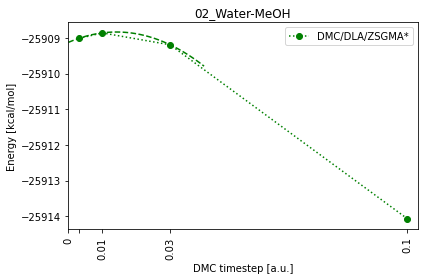

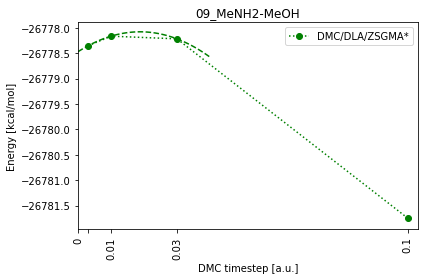

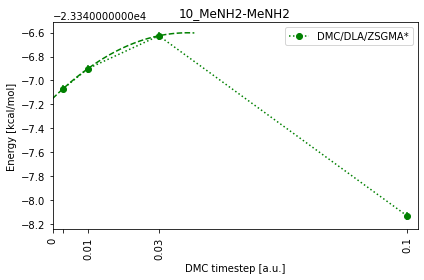

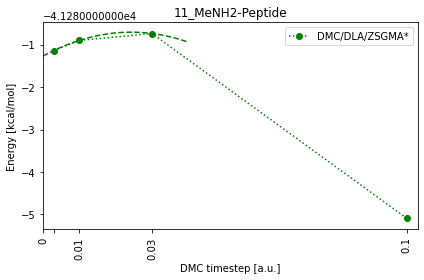

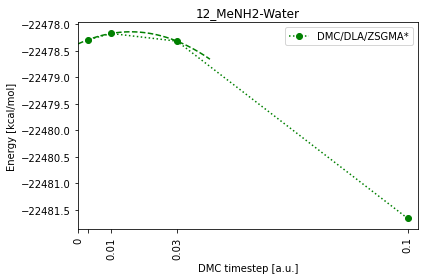

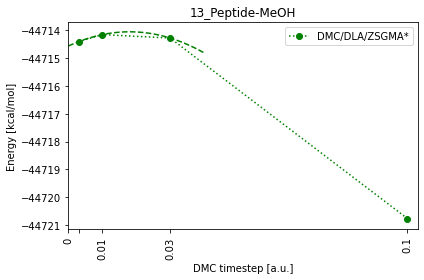

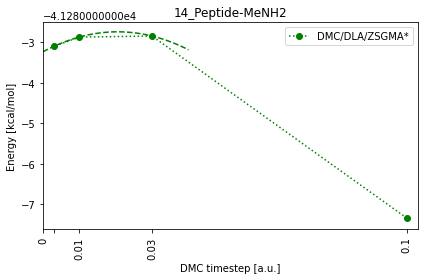

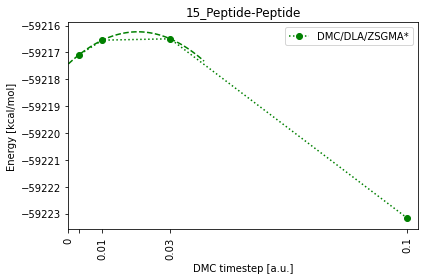

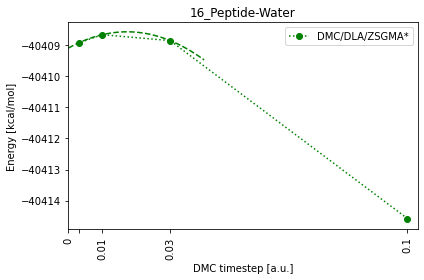

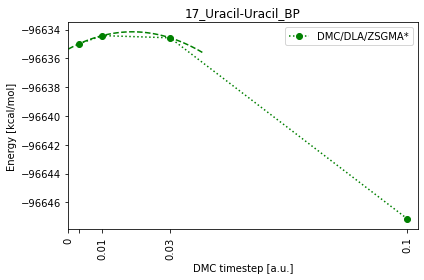

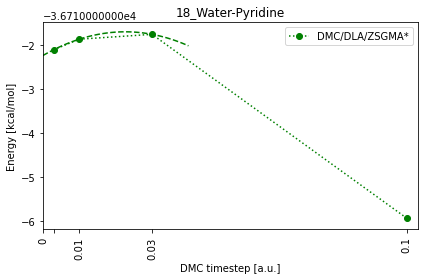

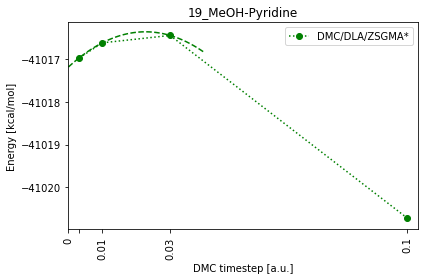

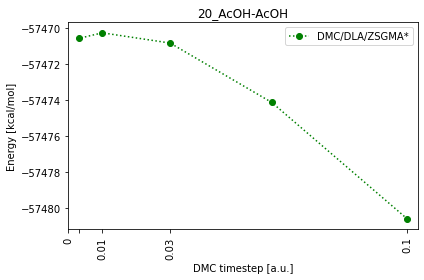

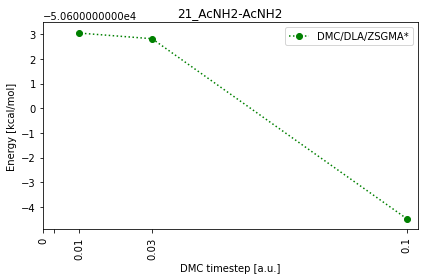

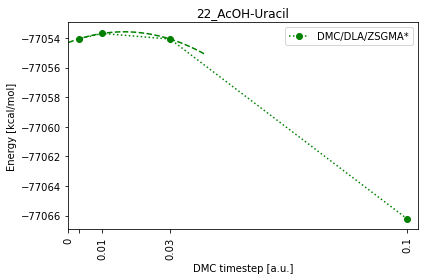

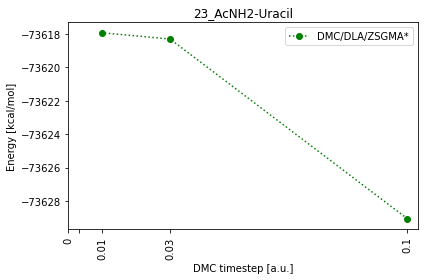

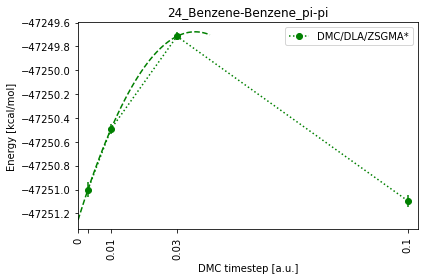

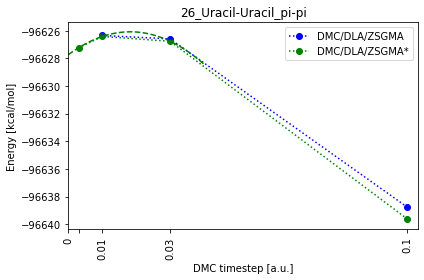

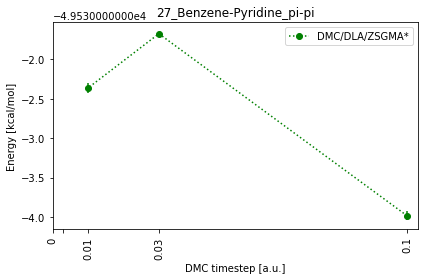

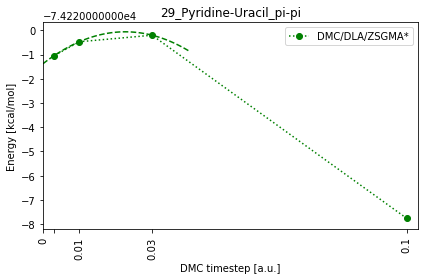

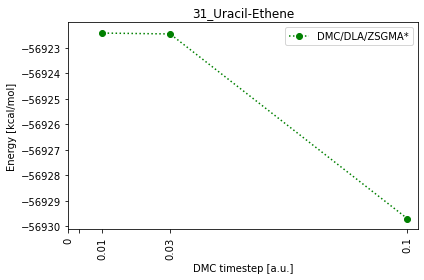

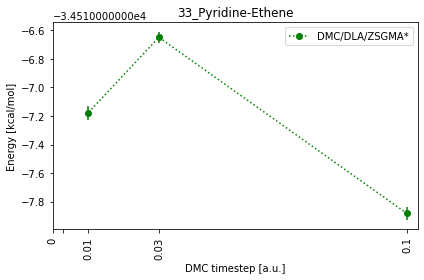

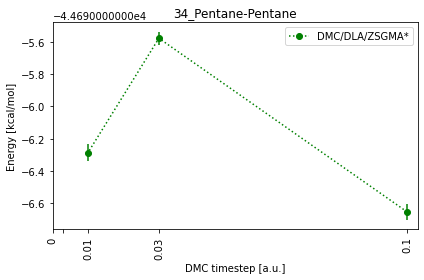

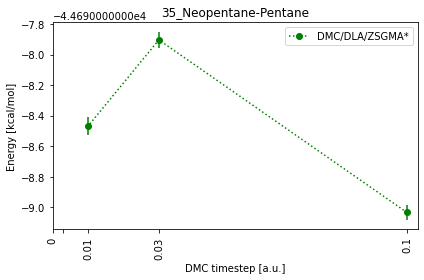

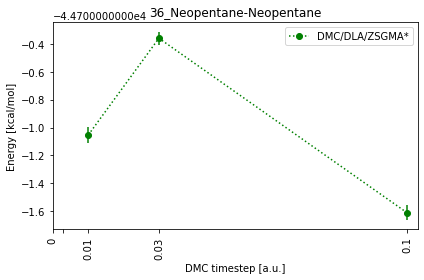

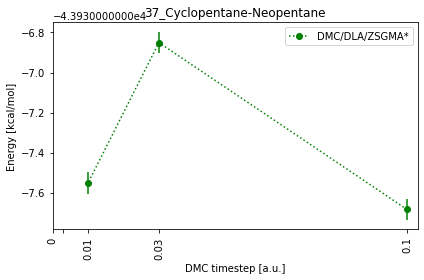

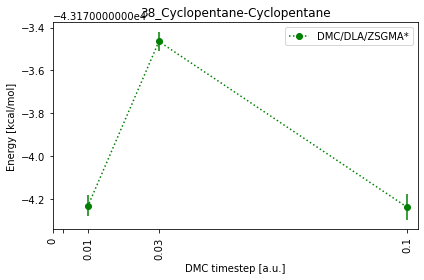

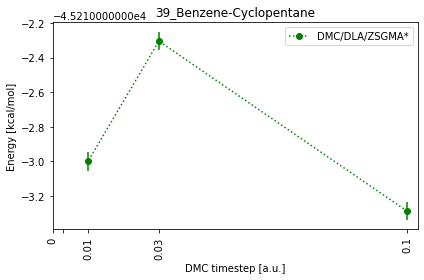

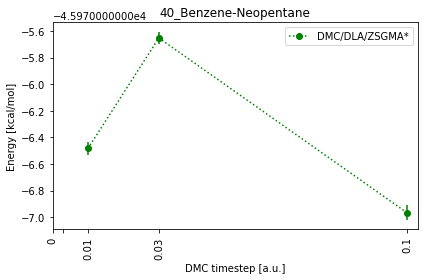

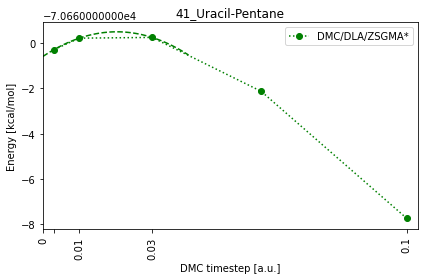

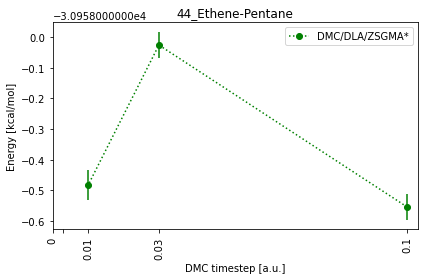

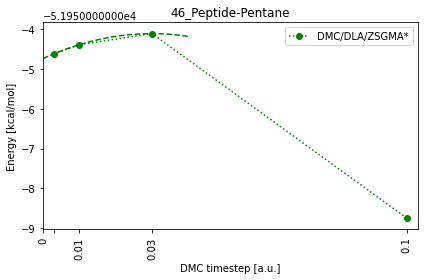

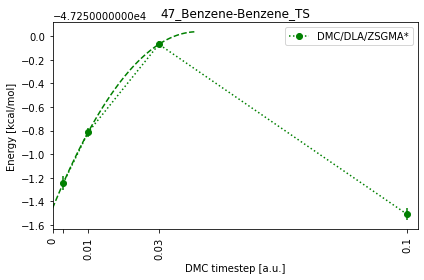

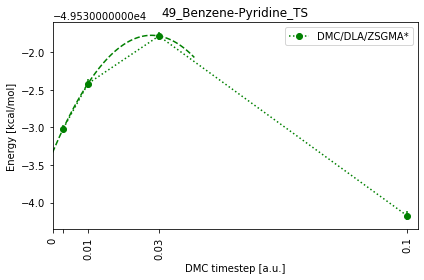

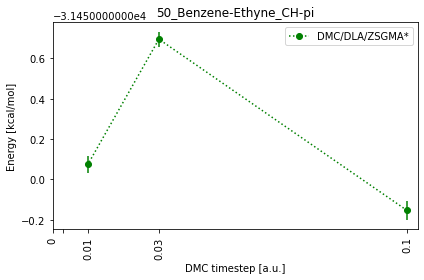

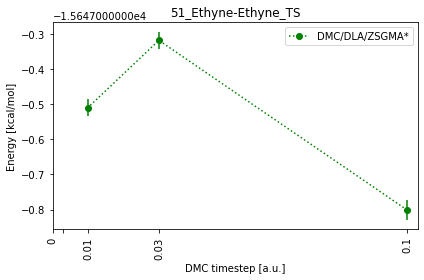

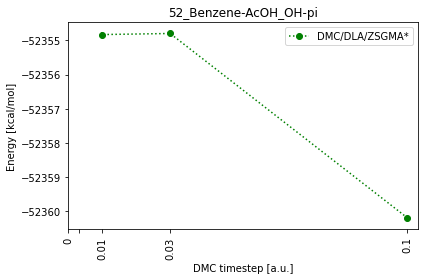

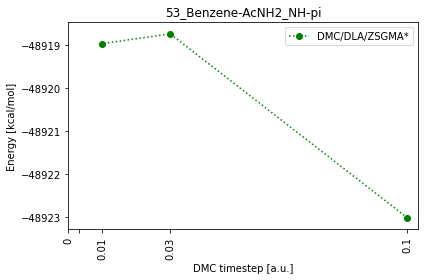

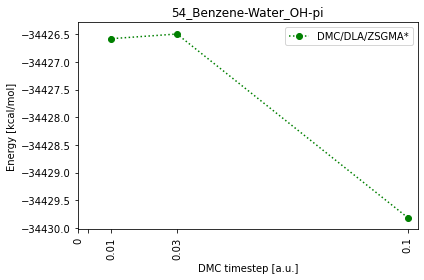

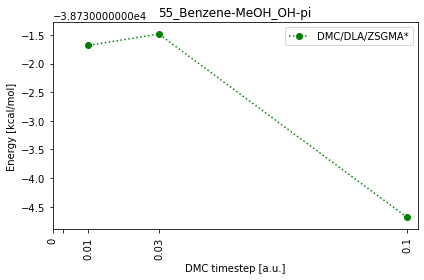

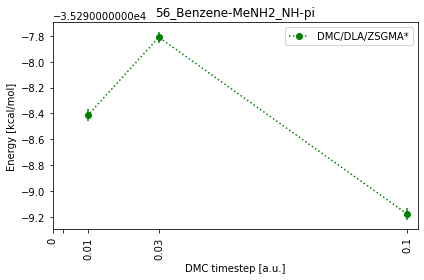

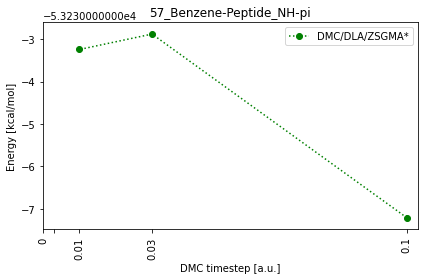

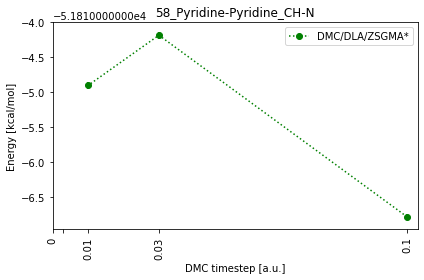

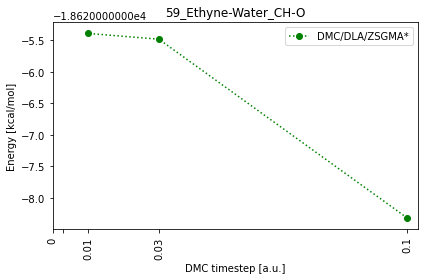

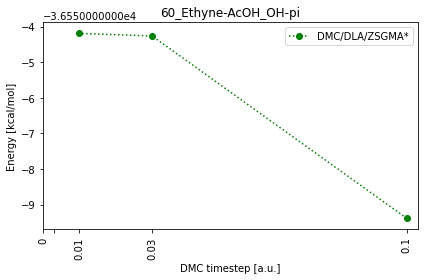

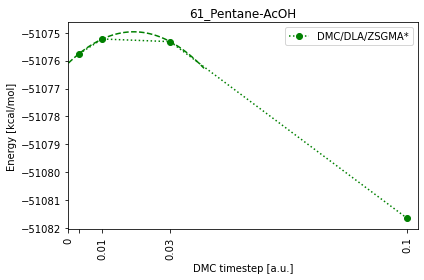

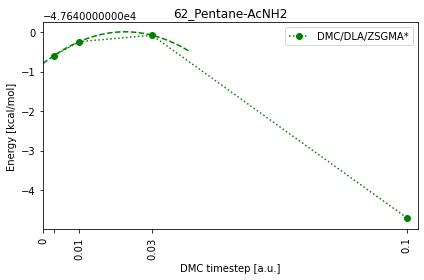

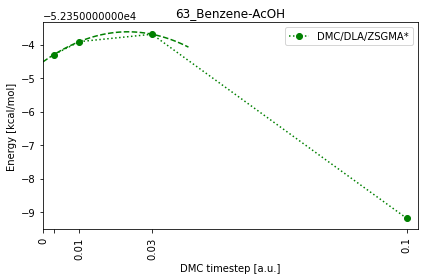

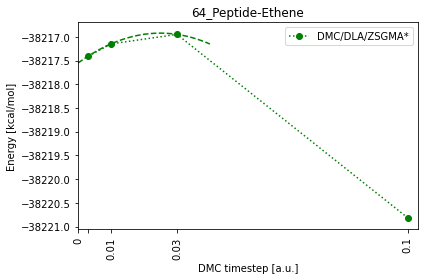

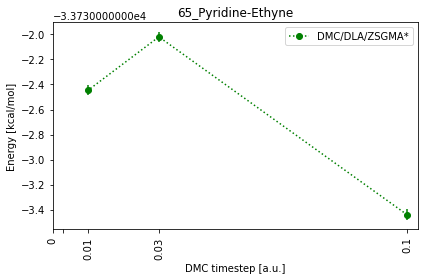

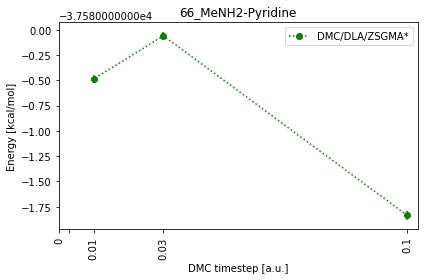

In [9]:
# Plot Total Energy for 66 dimers using dataframe Edimer

verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        print( f'{i} {dmc_type}' )

        dd = d[ d['dmc_type']==dmc_type ]
        X = dd['tau']
        Y = dd['ene']
        Yerr = dd['err']
        label = map_DMC( dmc_type )
        c = dmc_color( dmc_type )
        
        ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
        ax.plot( X, Y, 'o:', label=label , color=c )

        try:
            ddfit = dd[ dd['tau']<=0.03 ]
            xdata = ddfit['tau'].to_numpy()
            ydata = ddfit['ene'].to_numpy()
            sigma = ddfit['err'].to_numpy()
            popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
            xlinspace = np.linspace( 0, 0.04, 100 )
            funlinspace = fun_quad( xlinspace, *popt )
            ax.plot( xlinspace, funlinspace, '--', color=c )
        except:
            pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Etot_{i}.png',format='png')

1 01_Water-Water
1 DMCdla5 Jopt
fit Eb = -5.176460501466548
1 DMCdla5 Jdimer
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.846985573692229
2 DMCdla5 Jdimer
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.179993268706318
3 DMCdla5 Jdimer
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.553968103661722
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -5.964760349061753
5 DMCdla5 Jdimer
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.835196601025846
6 DMCdla5 Jdimer
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.638302509631016
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.264324022234652
8 DMCdla5 Jdimer
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1027120653220974
9 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.21604387683121
10 DMCdla5 Jdimer
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.593060355539256
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.541552045282455
12 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.456506886031222
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.643815470362478
14 DMCdla5 Jdimer
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.876069383422443


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.36140891610592
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt
fit Eb = -17.90481552978493
18 18_Water-Pyridine
18 DMCdla5 Jopt
fit Eb = -7.298450391933714
18 DMCdla5 Jdimer
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
fit Eb = -7.895208159024089
19 DMCdla5 Jdimer
20 20_AcOH-AcOH
20 DMCdla5 Jopt
fit Eb = -20.17687306618488
21 21_AcNH2-AcNH2
21 DMCdla5 Jopt
fit Eb = -16.890693908063053


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_24948/3678923703.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


22 22_AcOH-Uracil
22 DMCdla5 Jopt
fit Eb = -20.611299902860313
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -20.04419299316456
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3665171961380893
24 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


25 25_Pyridine-Pyridine_pi-pi
25 DMCdla Jdimer
25 DMCdla5 Jopt
fit Eb = -3.5615117264415574
25 DMCdla5 Jdimer
25 DMC Jdimer
26 26_Uracil-Uracil_pi-pi
26 DMCdla5 Jopt
fit Eb = -9.224478904170006


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.125887400614634
27 DMCdla5 Jdimer
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.075277348291836
28 DMCdla5 Jdimer
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.547993029372134
29 DMCdla5 Jdimer
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1021408192782534
30 DMCdla5 Jdimer
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.1758452049657317


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.4721448510477524
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.7067559456316388
33 DMCdla5 Jdimer
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.448610113480494
34 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.2875604180818696
35 DMCdla5 Jdimer
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.7150808852675257
36 DMCdla5 Jdimer
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

fit Eb = -2.157064587593638
37 DMCdla5 Jdimer
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
fit Eb = -3.0604533444297677
39 39_Benzene-Cyclopentane


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


39 DMCdla5 Jopt
fit Eb = -3.351097558625735
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
fit Eb = -2.8413473190907794
40 DMCdla5 Jdimer
41 41_Uracil-Pentane
41 DMCdla5 Jopt
fit Eb = -4.434605148753616


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
fit Eb = -3.584208066749159
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
fit Eb = -3.5070713047757005
44 44_Ethene-Pentane
44 DMCdla5 Jopt
fit Eb = -1.7375872637212093
44 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

45 45_Ethyne-Pentane
45 DMCdla5 Jopt
fit Eb = -1.4695663896960645
45 DMCdla5 Jdimer
46 46_Peptide-Pentane
46 DMCdla5 Jopt
fit Eb = -4.051269995678533
47 47_Benzene-Benzene_TS
47 DMCdla5 Jopt
fit Eb = -2.6203894709665003
47 DMCdla5 Jdimer
48 48_Pyridine-Pyridine_TS
48 DMCdla5 Jopt
fit Eb = -3.456976040782354
48 DMCdla5 Jdimer
49 49_Benzene-Pyridine_TS
49 DMCdla5 Jopt
fit Eb = -3.1503729435374446
49 DMCdla5 Jdimer
50 50_Benzene-Ethyne_CH-pi


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


50 DMCdla5 Jopt
fit Eb = -2.9385157268535695
50 DMCdla5 Jdimer
51 51_Ethyne-Ethyne_TS
51 DMCdla5 Jopt
fit Eb = -1.411574233840102
51 DMCdla5 Jdimer
52 52_Benzene-AcOH_OH-pi
52 DMCdla5 Jopt
fit Eb = -4.525976515641518
52 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

53 53_Benzene-AcNH2_NH-pi
53 DMCdla5 Jopt
fit Eb = -4.296937950686004
53 DMCdla5 Jdimer
54 54_Benzene-Water_OH-pi
54 DMCdla5 Jopt
fit Eb = -3.1514503618044336
54 DMCdla5 Jdimer
55 55_Benzene-MeOH_OH-pi
55 DMCdla5 Jopt
fit Eb = -3.9552695814121153
55 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

56 56_Benzene-MeNH2_NH-pi
56 DMCdla5 Jopt
fit Eb = -3.1678112258607487
56 DMCdla5 Jdimer
57 57_Benzene-Peptide_NH-pi
57 DMCdla5 Jopt
fit Eb = -5.134142348939003
57 DMCdla5 Jdimer
58 58_Pyridine-Pyridine_CH-N
58 DMCdla5 Jopt
fit Eb = -4.594933482957588
58 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

59 59_Ethyne-Water_CH-O
59 DMCdla5 Jopt
fit Eb = -2.9990073011545713
59 DMCdla5 Jdimer
60 60_Ethyne-AcOH_OH-pi


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


60 DMCdla5 Jopt
fit Eb = -5.052103523254725
61 61_Pentane-AcOH
61 DMCdla5 Jopt
fit Eb = -2.669212789698468
62 62_Pentane-AcNH2
62 DMCdla5 Jopt
fit Eb = -3.2027245893511695
63 63_Benzene-AcOH
63 DMCdla5 Jopt
fit Eb = -3.6905805466205313
64 64_Peptide-Ethene
64 DMCdla5 Jopt
fit Eb = -2.9568423044508694
65 65_Pyridine-Ethyne
65 DMCdla5 Jopt
fit Eb = -4.252696341765191
65 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

66 66_MeNH2-Pyridine
66 DMCdla5 Jopt
fit Eb = -4.001589318853283
66 DMCdla5 Jdimer


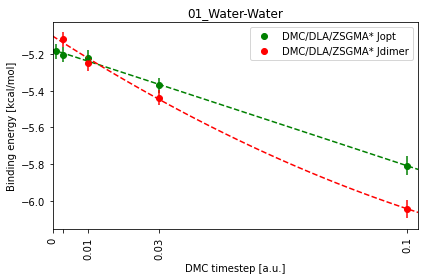

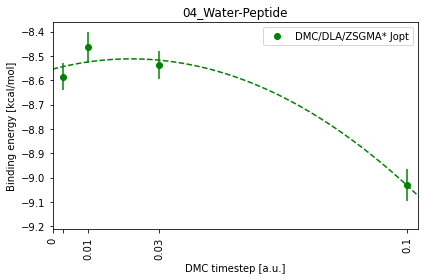

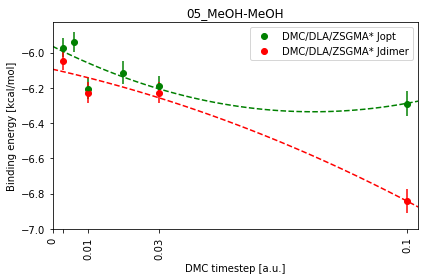

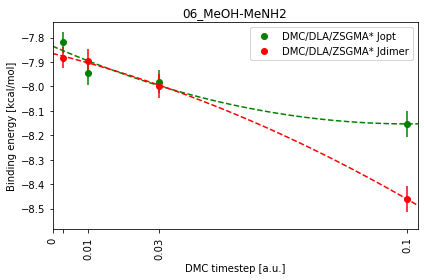

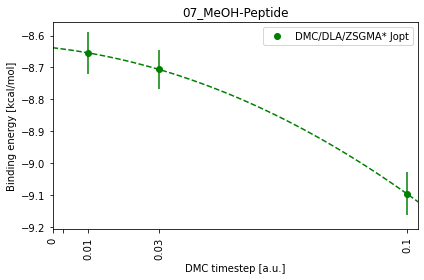

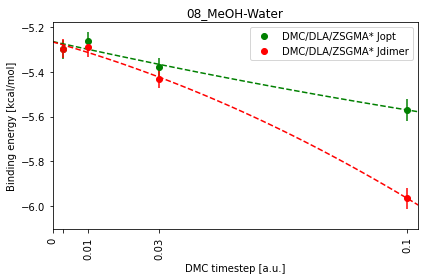

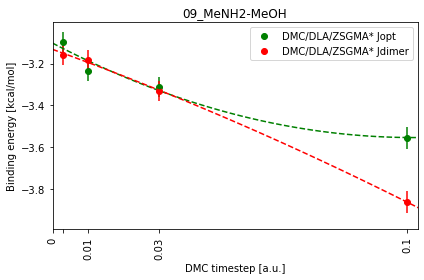

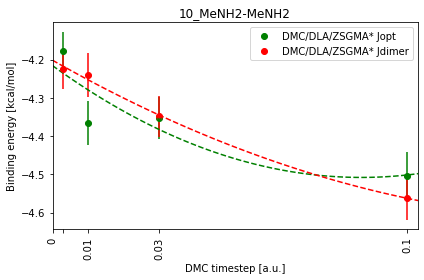

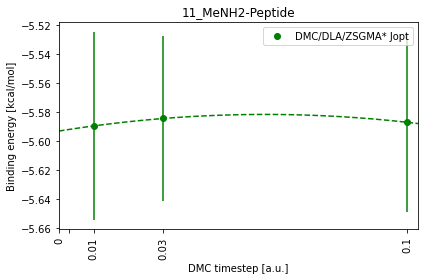

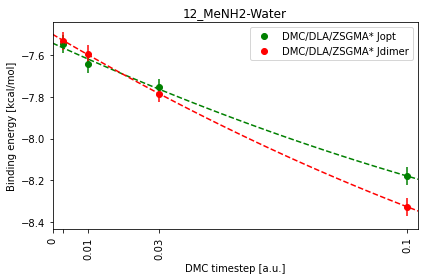

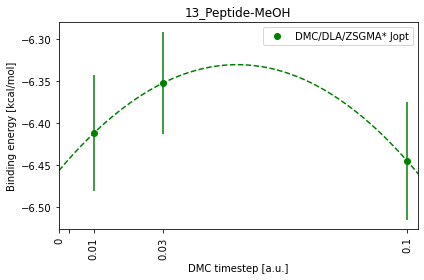

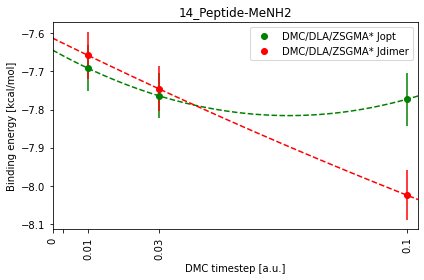

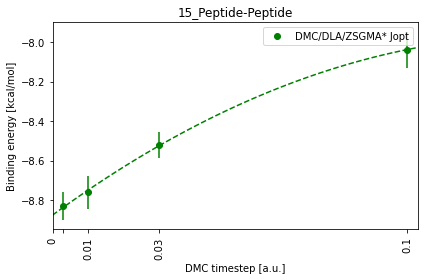

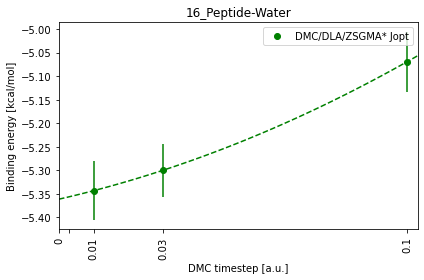

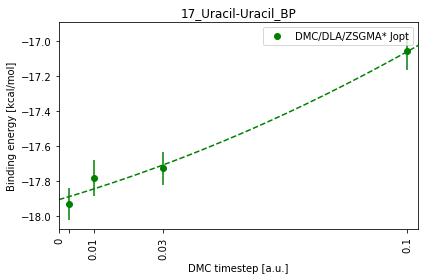

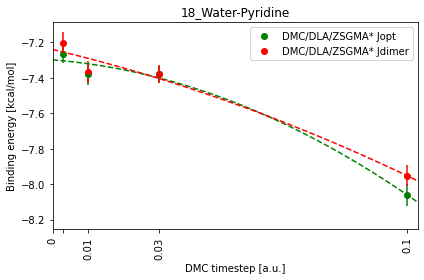

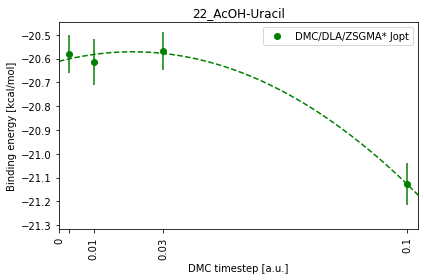

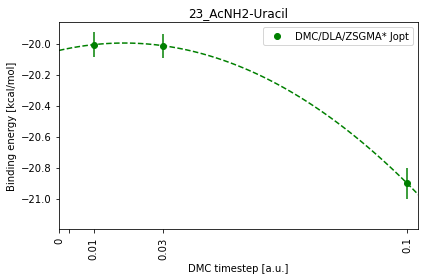

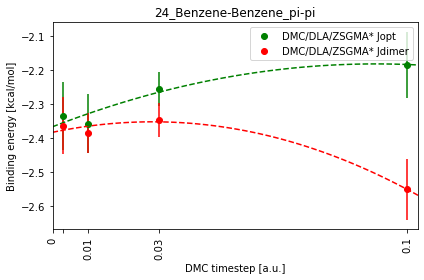

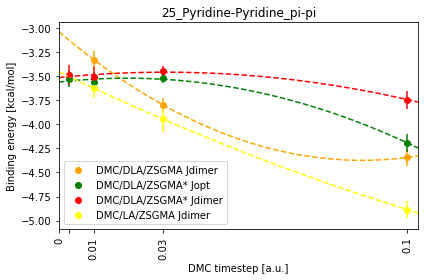

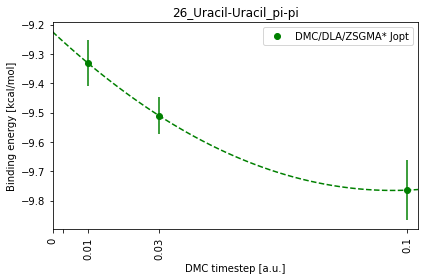

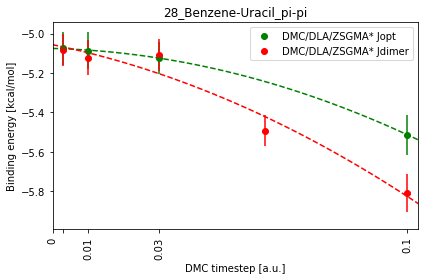

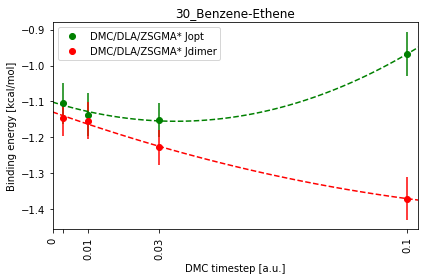

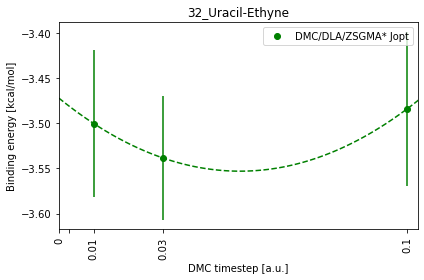

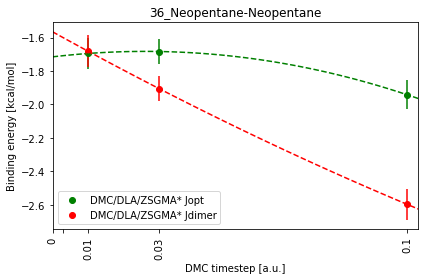

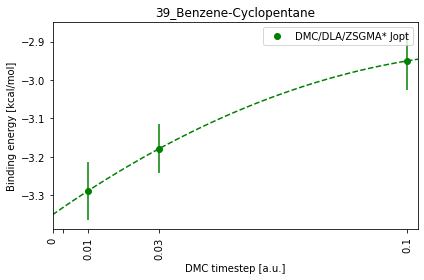

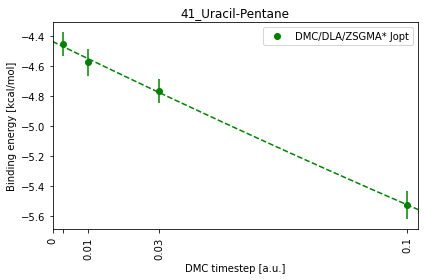

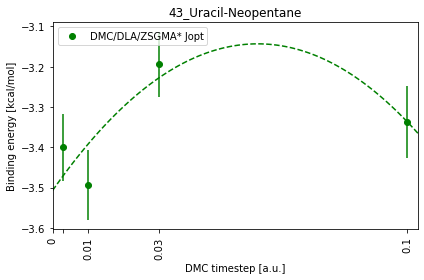

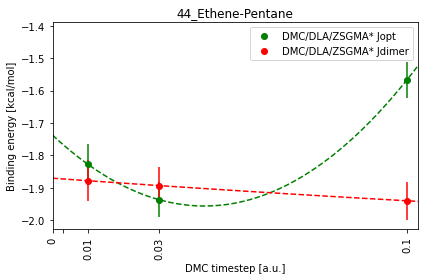

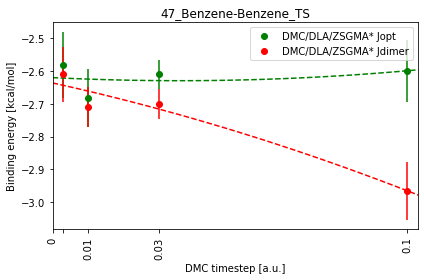

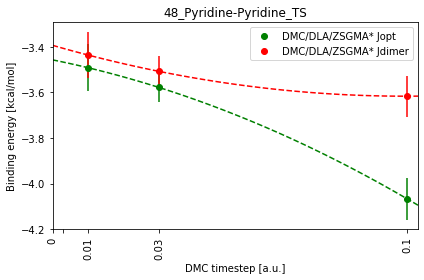

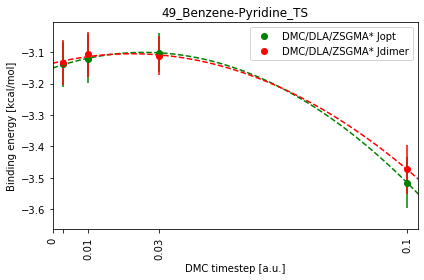

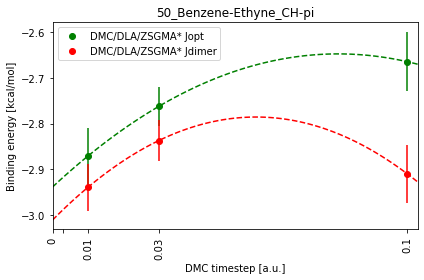

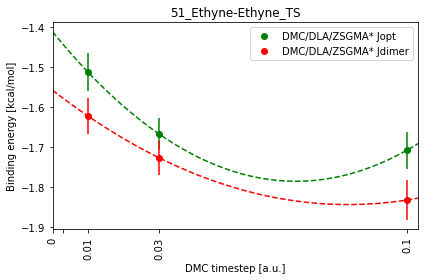

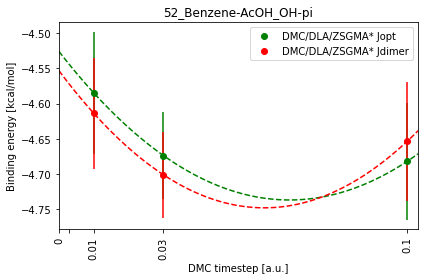

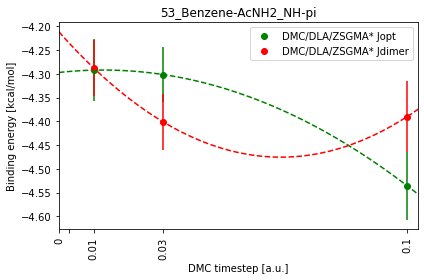

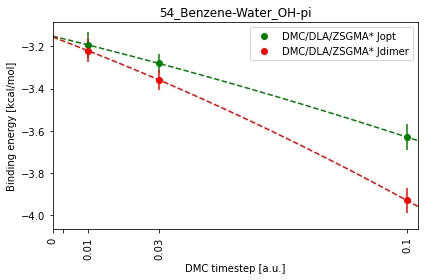

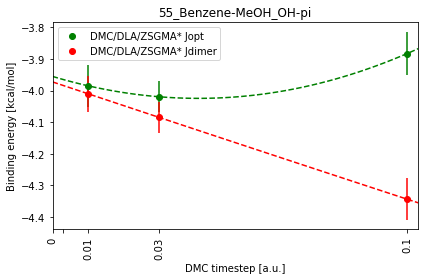

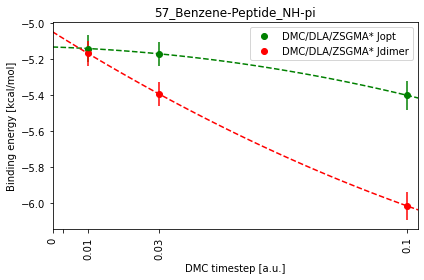

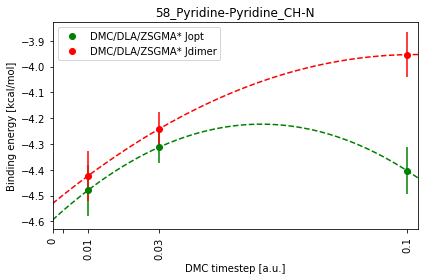

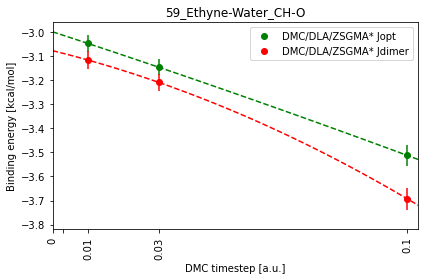

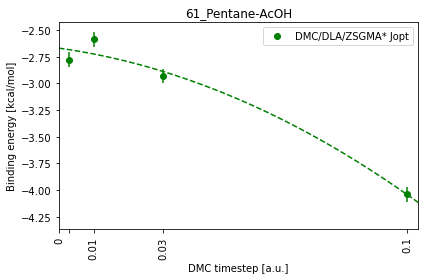

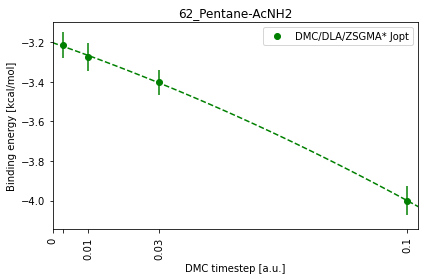

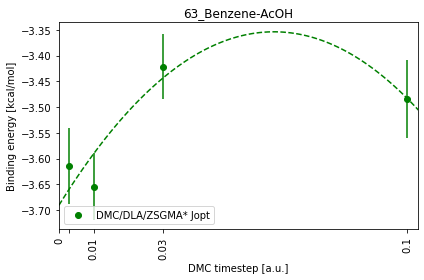

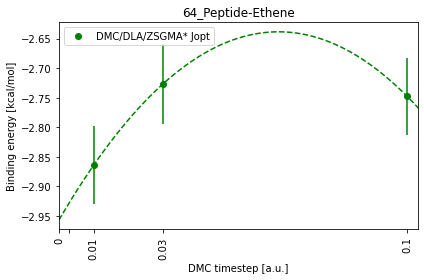

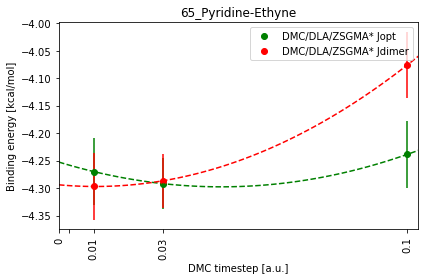

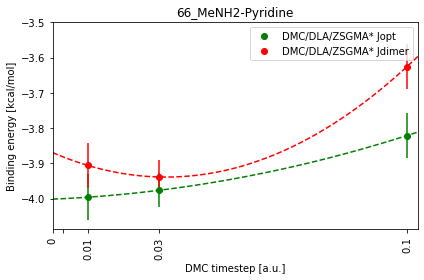

In [10]:
# Plot Binding Energy for 66 dimers using dataframe Eb
verbose = False

ref = {}
for i in range(1,67):
    d = Eb[ Eb['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )
            
            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass


#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb_{i}.png',format='png')

s = pd.Series( ref )
df_refs['DMC'] = s.values

1 01_Water-Water
1 DMCdla5 Jopt
fit Eb = -5.176460501466548
1 DMCdla5 Jdimer
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.846985573692229
2 DMCdla5 Jdimer
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.179993268706318
3 DMCdla5 Jdimer
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.527353582178446
4 DMCdla5 Jdimer
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -5.964760349061753
5 DMCdla5 Jdimer
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.835196601025846
6 DMCdla5 Jdimer
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.526071220076625
7 DMCdla5 Jdimer
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.264324022234652
8 DMCdla5 Jdimer
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1027120653220974
9 DMCdla5 Jdimer
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.21604387683121
10 DMCdla5 Jdimer
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.390034106526158
11 DMCdla5 Jdimer
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.541552045282455
12 DMCdla5 Jdimer
13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.305832819801195
13 DM

/tmp/ipykernel_24948/2533911534.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeW

23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -19.898268744500193
23 DMCdla5 Jdimer
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3665171961380893
24 DMCdla5 Jdimer
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla Jdimer
25 DMCdla5 Jopt
fit Eb = -3.5615117264415574
25 DMCdla5 Jdimer
25 DMC Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


26 26_Uracil-Uracil_pi-pi
26 DMCdla Jdimer
26 DMCdla5 Jopt
fit Eb = -9.293839155149412
26 DMCdla5 Jdimer
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.125887400614634
27 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.142448446883159
28 DMCdla5 Jdimer
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.383319276201369
29 DMCdla5 Jdimer
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1021408192782534
30 DMCdla5 Jdimer
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.2997078815404253
31 DMCdla5 Jdimer
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.5313615854220184
32 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.7067559456316388
33 DMCdla5 Jdimer
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.448610113480494
34 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.2875604180818696
35 DMCdla5 Jdimer
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.7150808852675257
36 DMCdla5 Jdimer
37 37_Cyclopentane-Neopentane


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

37 DMCdla5 Jopt
fit Eb = -2.157064587593638
37 DMCdla5 Jdimer
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
fit Eb = -2.8528919080861326
38 DMCdla5 Jdimer
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

fit Eb = -3.2196372244196976
39 DMCdla5 Jdimer
40 40_Benzene-Neopentane
40 DMCdla5 Jopt
fit Eb = -2.8413473190907794
40 DMCdla5 Jdimer
41 41_Uracil-Pentane
41 DMCdla5 Jopt
fit Eb = -4.43256791762358
41 DMCdla5 Jdimer
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
fit Eb = -3.608416284099746
42 DMCdla5 Jdimer
43 43_Uracil-Neopentane


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


43 DMCdla5 Jopt
fit Eb = -3.4857827798167427
43 DMCdla5 Jdimer
44 44_Ethene-Pentane
44 DMCdla5 Jopt
fit Eb = -1.7375872637212093
44 DMCdla5 Jdimer
45 45_Ethyne-Pentane


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

45 DMCdla5 Jopt
fit Eb = -1.4695663896960645
45 DMCdla5 Jdimer
46 46_Peptide-Pentane
46 DMCdla5 Jopt
fit Eb = -3.7886812376881784
46 DMCdla5 Jdimer
47 47_Benzene-Benzene_TS
47 DMCdla5 Jopt
fit Eb = -2.6203894709665003
47 DMCdla5 Jdimer
48 48_Pyridine-Pyridine_TS
48 DMCdla5 Jopt
fit Eb = -3.456976040782354
48 DMCdla5 Jdimer
49 49_Benzene-Pyridine_TS
49 DMCdla5 Jopt
fit Eb = -3.1503729435374446
49 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

50 50_Benzene-Ethyne_CH-pi
50 DMCdla5 Jopt
fit Eb = -2.9385157268535695
50 DMCdla5 Jdimer
51 51_Ethyne-Ethyne_TS
51 DMCdla5 Jopt
fit Eb = -1.411574233840102
51 DMCdla5 Jdimer
52 52_Benzene-AcOH_OH-pi
52 DMCdla5 Jopt


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

fit Eb = -4.404718896733919
52 DMCdla5 Jdimer
53 53_Benzene-AcNH2_NH-pi
53 DMCdla5 Jopt
fit Eb = -4.275792242547184
53 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

54 54_Benzene-Water_OH-pi
54 DMCdla5 Jopt
fit Eb = -3.1514503618044336
54 DMCdla5 Jdimer
55 55_Benzene-MeOH_OH-pi
55 DMCdla5 Jopt
fit Eb = -3.9552695814121153
55 DMCdla5 Jdimer
56 56_Benzene-MeNH2_NH-pi
56 DMCdla5 Jopt

/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 


fit Eb = -3.1678112258607487
56 DMCdla5 Jdimer
57 57_Benzene-Peptide_NH-pi
57 DMCdla5 Jopt
fit Eb = -5.134142348939003
57 DMCdla5 Jdimer
58 58_Pyridine-Pyridine_CH-N
58 DMCdla5 Jopt
fit Eb = -4.594933482957588
58 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

59 59_Ethyne-Water_CH-O
59 DMCdla5 Jopt
fit Eb = -2.9990073011545713
59 DMCdla5 Jdimer
60 60_Ethyne-AcOH_OH-pi
60 DMCdla5 Jopt
fit Eb = -4.945750236944324
60 DMCdla5 Jdimer
61 61_Pentane-AcOH
61 DMCdla5 Jopt

/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



fit Eb = -2.6246502351066496
61 DMCdla5 Jdimer
62 62_Pentane-AcNH2
62 DMCdla5 Jopt
fit Eb = -3.095089253949971
62 DMCdla5 Jdimer
63 63_Benzene-AcOH
63 DMCdla5 Jopt
fit Eb = -3.5443938817813514
63 DMCdla5 Jdimer
64 64_Peptide-Ethene
64 DMCdla5 Jopt
fit Eb = -2.7785644908570046
64 DMCdla5 Jdimer
65 65_Pyridine-Ethyne
65 DMCdla5 Jopt
fit Eb = -4.252696341765191
65 DMCdla5 Jdimer
66 66_MeNH2-Pyridine
66 DMCdla5 Jopt
fit Eb = -4.001589318853283
66 DMCdla5 Jdimer


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the 

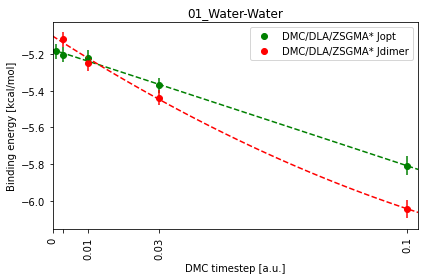

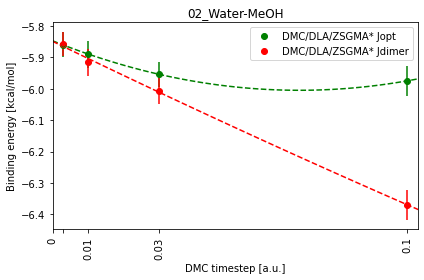

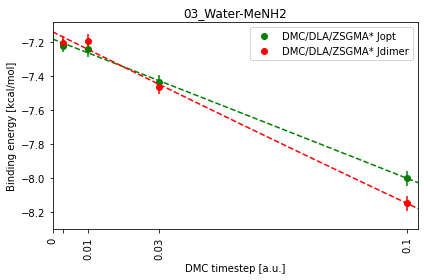

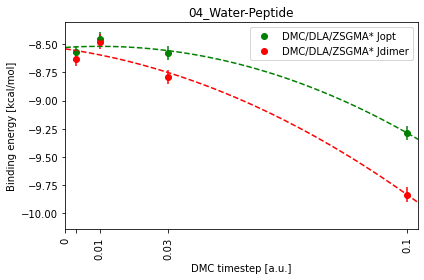

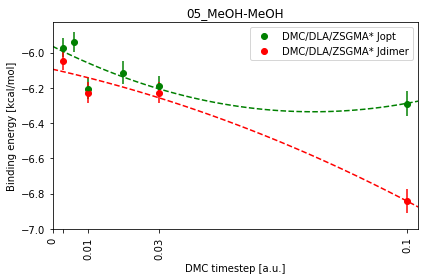

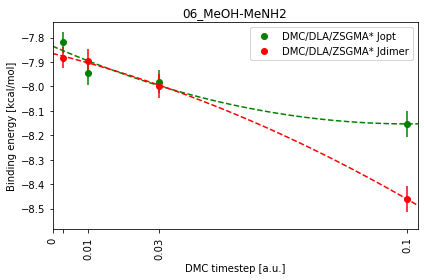

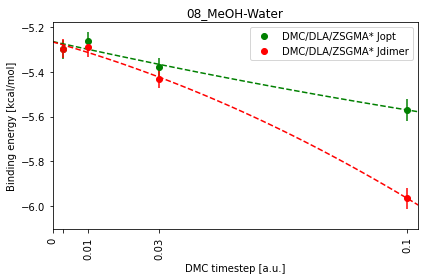

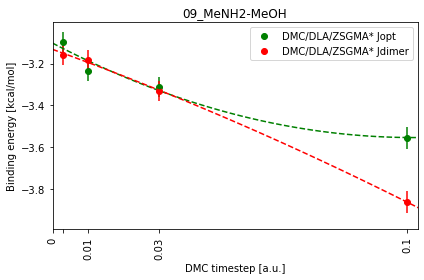

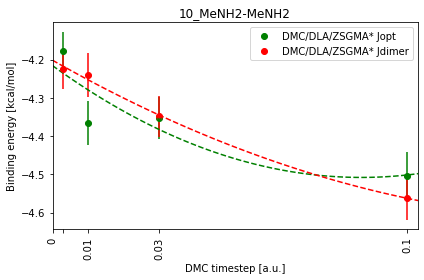

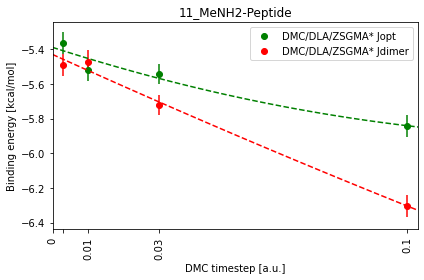

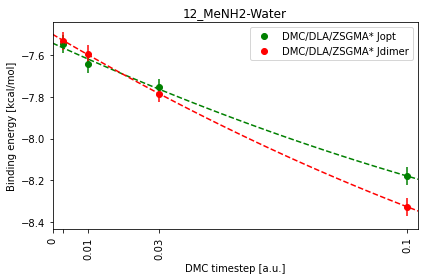

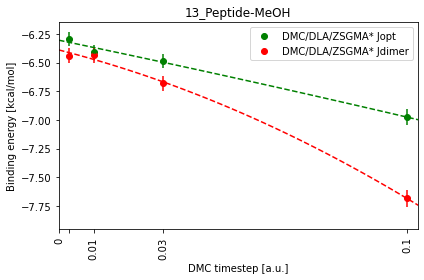

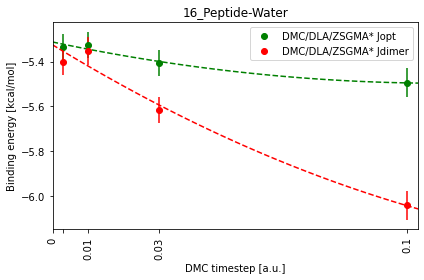

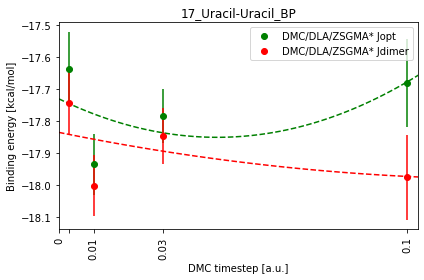

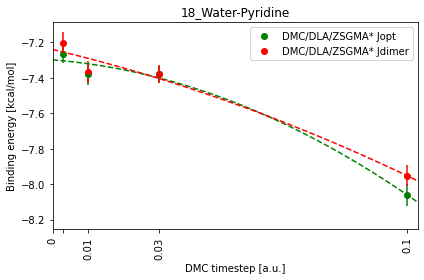

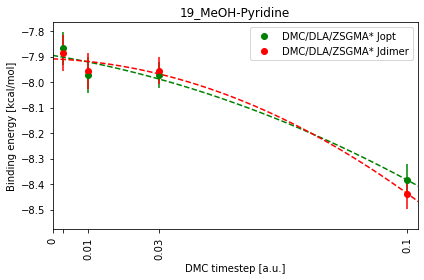

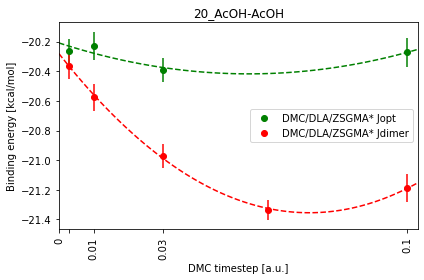

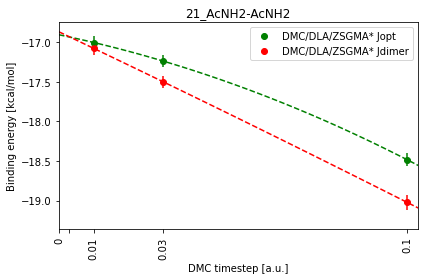

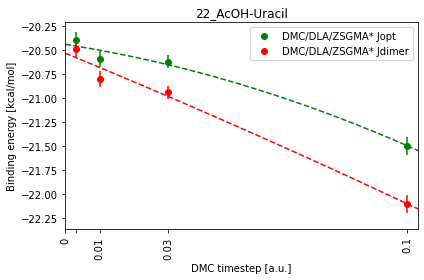

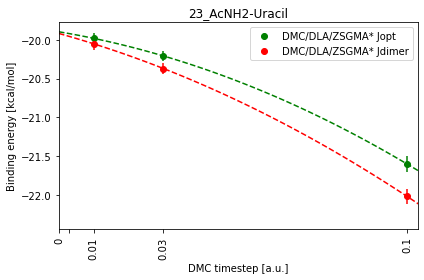

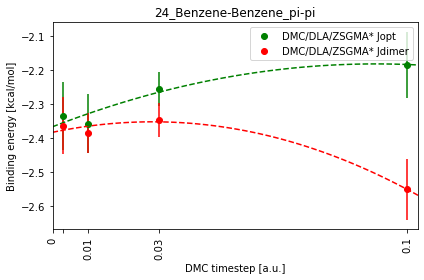

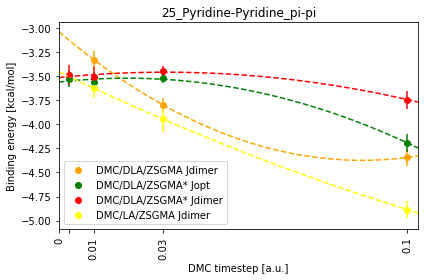

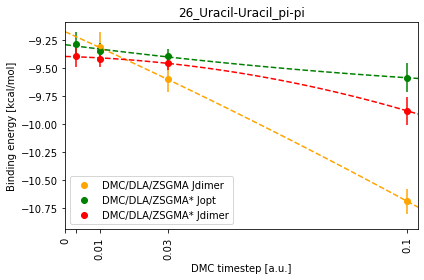

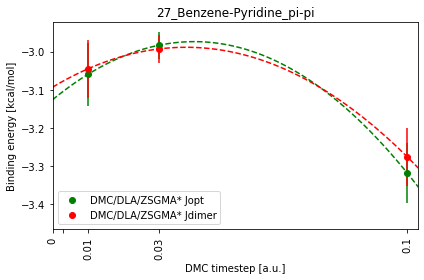

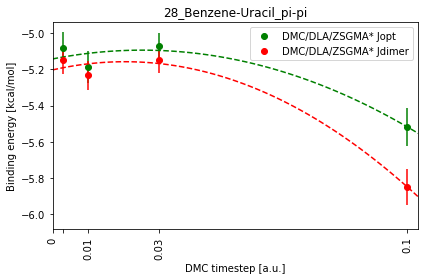

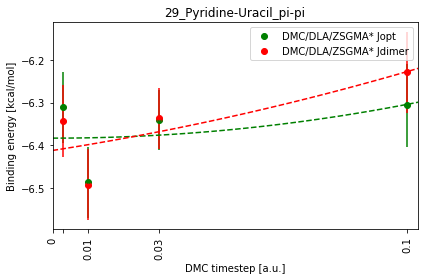

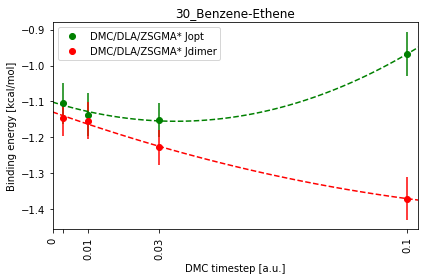

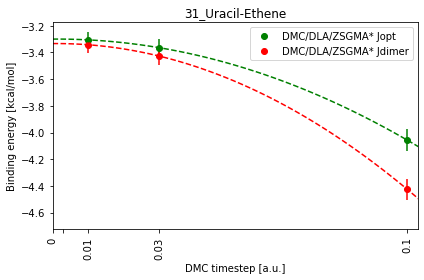

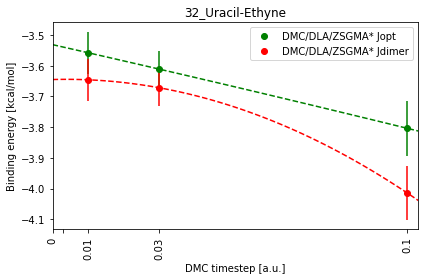

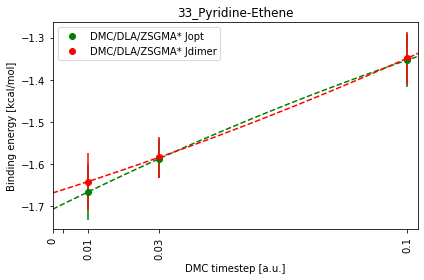

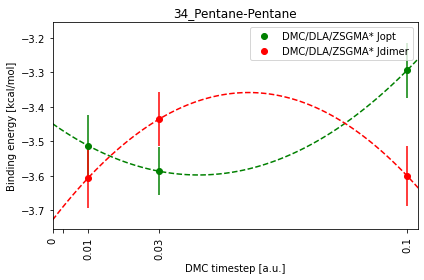

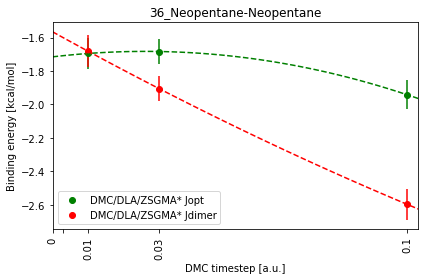

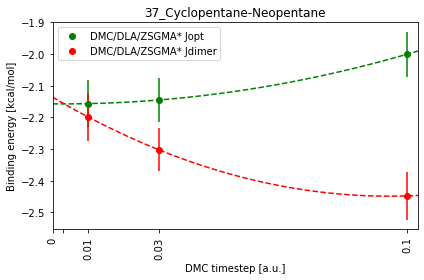

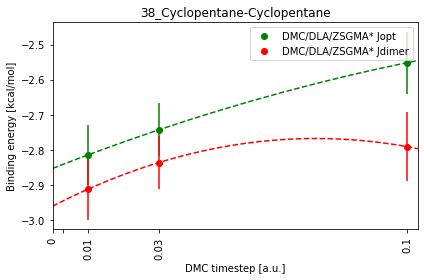

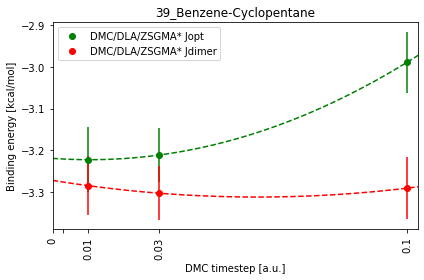

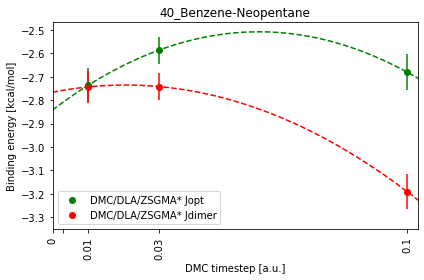

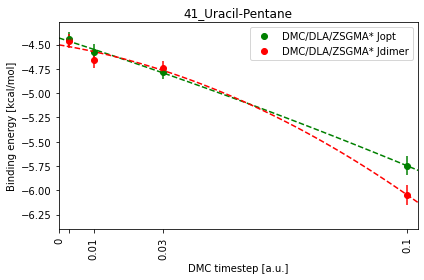

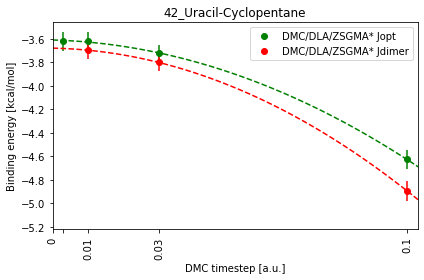

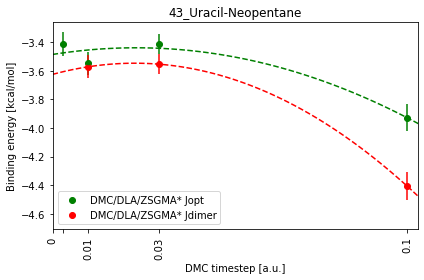

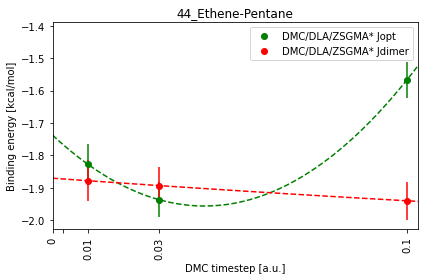

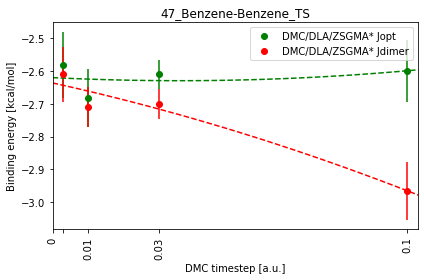

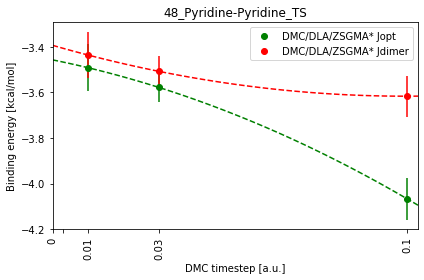

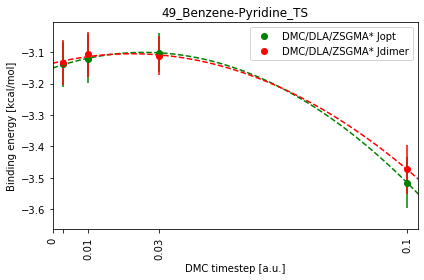

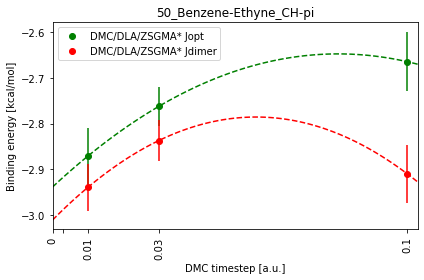

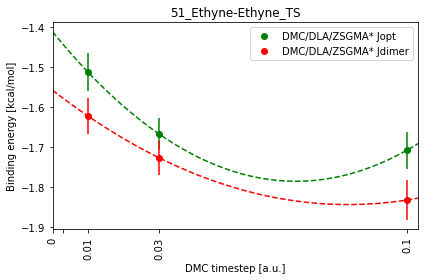

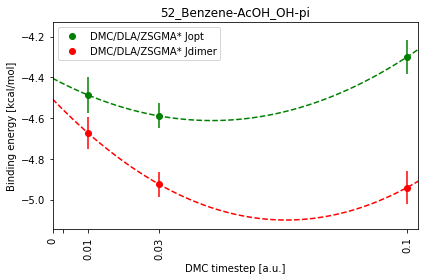

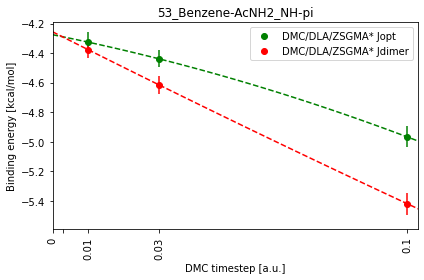

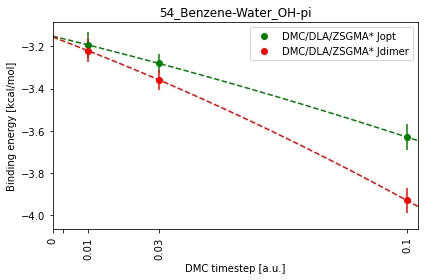

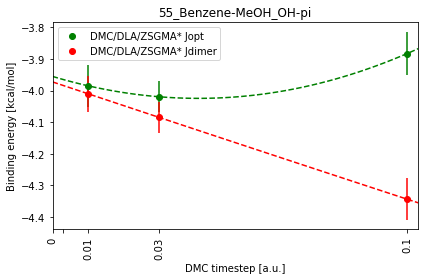

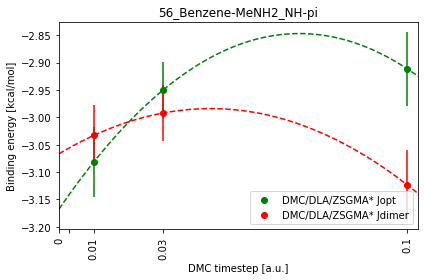

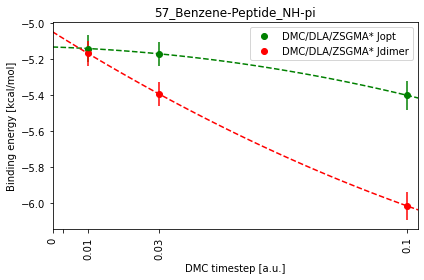

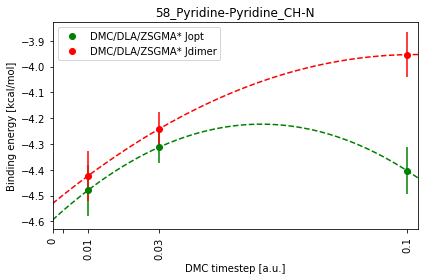

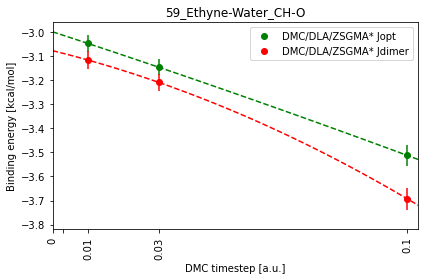

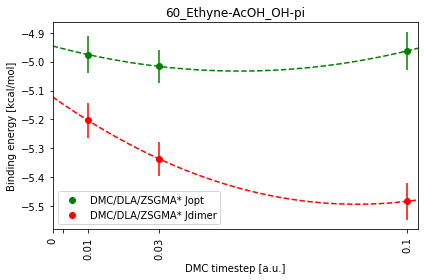

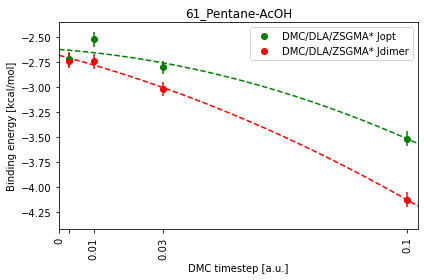

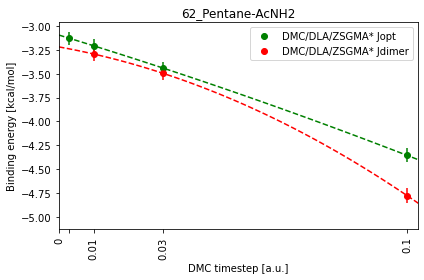

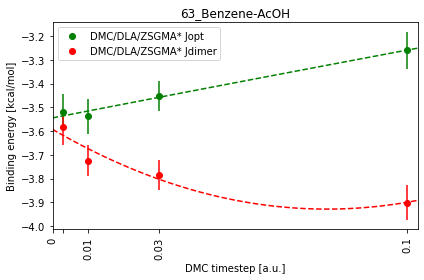

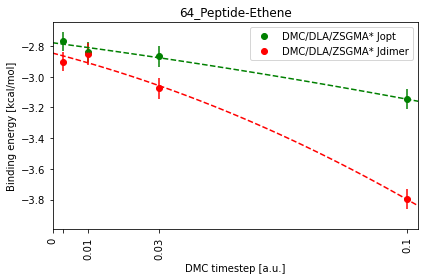

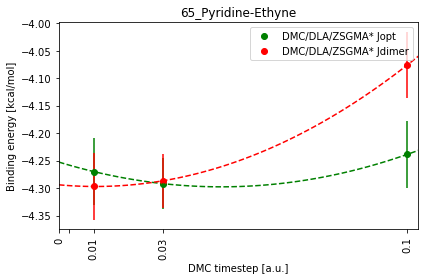

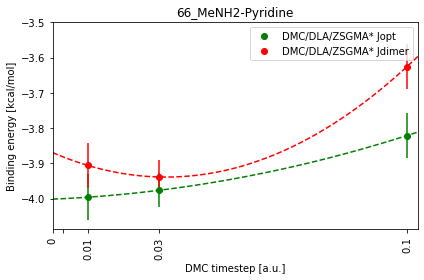

In [11]:
# Plot Binding Energy for 66 dimers using dataframe Eb_1ref
verbose = False

for i in range(1,67):
    d = Eb_1ref[ Eb_1ref['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )

            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb1ref_{i}.png',format='png')


s = pd.Series( ref )
df_refs['DMC_1ref'] = s.values

In [12]:
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_CCSDT(Q)       DMC  DMC_1ref  
1        -4.979              NaN -5.176461 -5.176461  
2        -5.666              NaN -5.846986 -5.846986  
3        -6.985              NaN -7.179993 -7.179993  
4           NaN              NaN -8.553968 -8.527354  
5        -5.824              NaN -5.964760 -5.964760  
..          ...              ...       ...       ...  
62          NaN              NaN -3.202725 -3.095089  
63          NaN              NaN -3.690581 -3.544394  
64          NaN              NaN -2.956842 -2.778564  
65          NaN              NaN -4.252696 -4.252696  
66          NaN              NaN -4.001589 -4.001589  

[66 rows x 9 columns]

In [13]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.003) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])

ene       err
1   -5.203357  0.039732
2   -5.859280  0.039057
3   -7.218353  0.038538
4   -8.584681  0.056614
5   -5.973319  0.054768
6   -7.820006  0.043533
8   -5.299090  0.042160
9   -3.096698  0.047923
10  -4.176916  0.049455
12  -7.547423  0.042428
15  -8.829642  0.071470
17 -17.929089  0.092103
18  -7.262831  0.052634
19  -7.867163  0.064454
22 -20.578795  0.079755
24  -2.334822  0.100676
25  -3.527459  0.084447
28  -5.075560  0.084624
30  -1.105148  0.057291
41  -4.451623  0.081508
43  -3.400320  0.083112
47  -2.582216  0.101447
49  -3.138373  0.071306
61  -2.777775  0.070153
62  -3.215191  0.067234
63  -3.614525  0.074649

In [14]:
df_refs['DMC(0.003)'] = aus.ene
df_refs['err_DMC(0.003)'] = aus.err
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_CCSDT(Q)       DMC  DMC_1ref  DMC(0.003)  \
1        -4.979              NaN -5.176461 -5.176461   -5.203357   
2        -5.666              NaN -5.846986 -5.846986   -5.859280   
3        -6.985              NaN -7.179993 -7.179993   -7.218353   
4           NaN              NaN -8.553968 -8.527354   -8.584681   
5        -5.824              NaN -5.964760 -5.964760   -5.973319   
..          ...              ...       ...       ...         ...   
62          NaN              NaN -3.202725 -3.095089   -3.215191   
63          NaN              NaN -3.690581 -3.544394   -3.614525   
64          NaN              NaN -2.956842 -2.778564         NaN   
65          NaN              NaN -4.252696 -4.252696         NaN   
66          NaN              NaN -4.001589 -4.001589         NaN   

    err_DMC(0.003)  
1         0.039732  
2         0.039057  
3         0.038538  
4         0.056614  
5         0.054768  
..             ...  
62        0.067234  
63        0.074649  
64             NaN  
65             NaN  
66             NaN  

[66 rows x 11 columns]

In [15]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.01) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])
df_refs['DMC(0.01)'] = aus.ene
df_refs['err_DMC(0.01)'] = aus.err
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_CCSDT(Q)       DMC  DMC_1ref  DMC(0.003)  \
1        -4.979              NaN -5.176461 -5.176461   -5.203357   
2        -5.666              NaN -5.846986 -5.846986   -5.859280   
3        -6.985              NaN -7.179993 -7.179993   -7.218353   
4           NaN              NaN -8.553968 -8.527354   -8.584681   
5        -5.824              NaN -5.964760 -5.964760   -5.973319   
..          ...              ...       ...       ...         ...   
62          NaN              NaN -3.202725 -3.095089   -3.215191   
63          NaN              NaN -3.690581 -3.544394   -3.614525   
64          NaN              NaN -2.956842 -2.778564         NaN   
65          NaN              NaN -4.252696 -4.252696         NaN   
66          NaN              NaN -4.001589 -4.001589         NaN   

    err_DMC(0.003)  DMC(0.01)  err_DMC(0.01)  
1         0.039732  -5.221658       0.042958  
2         0.039057  -5.890482       0.043269  
3         0.038538  -7.241137       0.042855  
4         0.056614  -8.464290       0.063732  
5         0.054768  -6.204940       0.060346  
..             ...        ...            ...  
62        0.067234  -3.276277       0.070684  
63        0.074649  -3.654620       0.064675  
64             NaN  -2.863896       0.065566  
65             NaN  -4.269927       0.061694  
66             NaN  -3.995998       0.064844  

[66 rows x 13 columns]

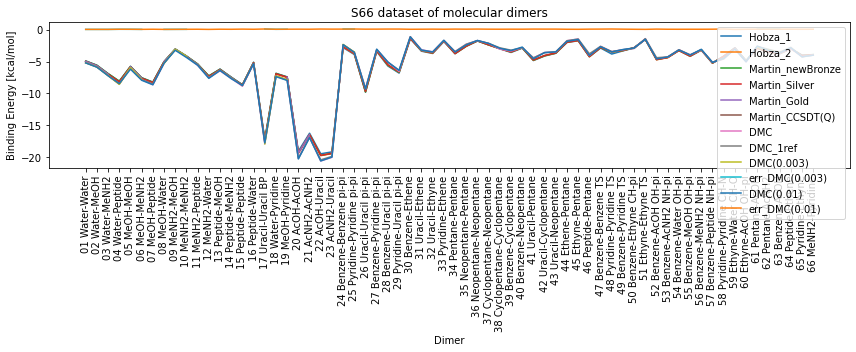

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
#fig, ax = plt.subplots()# figsize=(30,5) )
#df_refs.Hobza_1.plot( )
#df_refs.Hobza_2.plot( )
ax = df_refs.plot( xticks=range(1,67), rot=90, 
            title = 'S66 dataset of molecular dimers',
            xlabel = 'Dimer',
            ylabel = 'Binding Energy [kcal/mol]' )
ax.set_xticklabels( df_refs.name )
plt.tight_layout()
plt.savefig('Refs_all.png')
plt.rcdefaults()

In [17]:
# Plot difference between references 

delta_refs = pd.DataFrame()
for i in df_refs.columns:
    if i != 'name' and not i.startswith('err') :
        print(i)
        delta_refs[i] = df_refs[i] - df_refs.Hobza_1

import matplotlib.pyplot as plt
fig, (ax2,ax) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
#plt.rcParams["figure.figsize"] = (7, 12)
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Refs - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
#for ref in ['Hobza_1','Hobza_2','Martin_newBronze','Martin_Silver']:
for ref in df_refs.columns:
    if ref != 'name' and not i.startswith('err'):
        ax2.plot( df_refs[ref], df_refs.index-1, 'o', label=ref )
ax2.set_xlabel( 'Binding Energy [kcal/mol]' )
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('Refs_all_delta.png')

plt.rcdefaults()

Hobza_1
Hobza_2
Martin_newBronze
Martin_Silver
Martin_Gold
Martin_CCSDT(Q)
DMC
DMC_1ref
DMC(0.003)
DMC(0.01)


No handles with labels found to put in legend.


In [18]:
# Plot relative difference between references 

rdelta_refs = delta_refs.copy()
for i in delta_refs.columns:
    rdelta_refs[i] = delta_refs[i] / df_refs.Hobza_1

fig, (ax,ax2) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Difference: Ref - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
rdelta_refs.plot(kind='barh', rot=0, grid=True,
                title='Relative difference', 
                xlabel='', legend=False,
                ax=ax2)
ax2.set_xlabel( r'$\Delta E / E$ ' )

plt.tight_layout()
plt.savefig('Refs_all_delta_relative.png')

plt.rcdefaults()

In [19]:
# Plot relative difference between references 

fig, ax = plt.subplots()
delta_refs.plot.scatter( x='Hobza_2', y='DMC',
                title='Difference: Ref - Hobza_1', 
                ax=ax)
ax.set_xlabel( 'Hobza_2' )
ax.set_ylabel( 'DMC' )

plt.tight_layout()
plt.savefig('Refs_all_delta_scatter.png')

plt.rcdefaults()

In [20]:
from pandas.plotting import scatter_matrix
scatter_matrix( delta_refs.iloc[ :,1: ], alpha=0.5, figsize=(10,10) )

array([[<AxesSubplot:xlabel='Hobza_2', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='Martin_newBronze', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='Martin_Silver', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='Martin_Gold', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='Martin_CCSDT(Q)', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='DMC', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='DMC_1ref', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='DMC(0.003)', ylabel='Hobza_2'>,
        <AxesSubplot:xlabel='DMC(0.01)', ylabel='Hobza_2'>],
       [<AxesSubplot:xlabel='Hobza_2', ylabel='Martin_newBronze'>,
        <AxesSubplot:xlabel='Martin_newBronze', ylabel='Martin_newBronze'>,
        <AxesSubplot:xlabel='Martin_Silver', ylabel='Martin_newBronze'>,
        <AxesSubplot:xlabel='Martin_Gold', ylabel='Martin_newBronze'>,
        <AxesSubplot:xlabel='Martin_CCSDT(Q)', ylabel='Martin_newBronze'>,
        <AxesSubplot:xlabel='DMC', ylabel='Martin_newBronze'>,
        <AxesSubplot:xl